# MNIST Classification (softmax regression)

In this notebook, I implement a Dense Neural Network with softmax regression from scratch on the MNIST Dataset. I also have added L2 regularization in the code



In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

from scipy.io import loadmat
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
mnist = loadmat('/content/gdrive/MyDrive/pyhon/mnist-original.mat')
# mnist = loadmat('mnist-original.mat')

X = mnist['data'] # number of examples placed in row, features in column
Y = mnist['label']
Y = Y.astype('int')

n = X.shape[0]
m = Y.shape[1]

In [ ]:
print(X.shape, Y.shape)
print(f"The number of training examples: {m}, feature vector length: {n}")
print(Y)

img_size = np.sqrt(n).astype('int')
print(f"The image size is: {img_size} x {img_size}")

(784, 70000) (1, 70000)
The number of training examples: 70000, feature vector length: 784
[[0 0 0 ... 9 9 9]]
The image size is: 28 x 28


In [ ]:
print(mnist)
print(f"X: {X.shape}, Y: {Y.shape}")

print(f"Examples: {m}, Feature count: {n}")




{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar 30 03:19:02 2014', '__version__': '1.0', '__globals__': [], 'mldata_descr_ordering': array([[array(['label'], dtype='<U5'), array(['data'], dtype='<U4')]],
      dtype=object), 'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'label': array([[0., 0., 0., ..., 9., 9., 9.]])}
X: (784, 70000), Y: (1, 70000)
Examples: 70000, Feature count: 784


In [ ]:
img_size = int(np.sqrt(X.shape[0]))
print(f"The size of the image is {img_size} x {img_size}")

The size of the image is 28 x 28


In [ ]:
# Converting Y into one hot encoded labels

def oneHot(Y):
    m = Y.shape[1]
    classes = np.max(Y) + 1 # find max value of Y, number of classes should be max + 1, assuming zero indexing
    Yhot = np.zeros((classes, m))
    for i in range(m):
        Yhot[Y[:,i],i] = 1

    return Yhot


In [ ]:
Yhot = oneHot(Y)

print(Yhot.shape)

(10, 70000)


In [ ]:
def img_gen(X, Y):
    m = X.shape[1]
    n = X.shape[0]

    img_size = np.sqrt(n).astype('int')
    arb = np.random.randint(0, m)
    img = X[:,arb].reshape(img_size, img_size)

    Yhot = oneHot(Y)

    print(f"The image below is the {arb}th image in the dataset, labeled {Y[:,arb]}, with one hot encoding {Yhot[:,arb]}")
    plt.imshow(img)

The image below is the 24023th image in the dataset, labeled [3], with one hot encoding [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


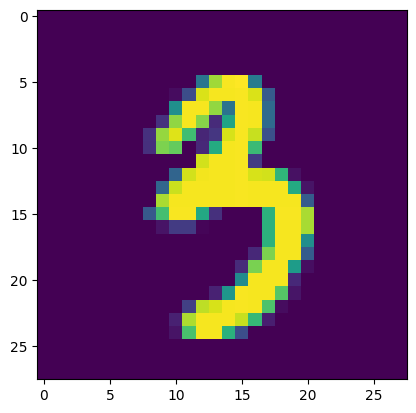

In [ ]:
img_gen(X, Y)

In [ ]:
# creating a normalization function

def normalize(data):
    # normalizing along rows because each column may have all zeros, i.e, black pixels in the edges of every image.
    mean = np.mean(data, axis=0, keepdims=True)
    std = np.std(data, axis=0, keepdims=True)
    data_normalized = (data - mean)/std

    # norms = np.linalg.norm(data_normalized, axis = 1)
    # max_norm = norms.max()
    # data_normalized = data_normalized / max_norm
    return data_normalized

In [ ]:
X_norm = normalize(X)

print(np.linalg.norm(X_norm, axis = 0).max()) # sanity check

28.00000000000001


In [ ]:
# Split to train and test

X_train, X_test, Y_train, Y_test = train_test_split(X_norm.T, Y.T, test_size=0.20, random_state=42)
Y_train = Y_train.reshape(-1,1).T
Y_test = Y_test.reshape(-1,1).T
X_train = X_train.T
X_test = X_test.T

print("The shape of the training set feature matrix is:", X_train.shape)
print("The shape of the training label vector is:", Y_train.shape)
print("The shape of the test set feature matrix is:", X_test.shape)
print("The shape of the test label vector is:", Y_test.shape)

print(np.sum((Y_train==0).astype(int)))
print(np.sum((Y_test==0).astype(int)))

The shape of the training set feature matrix is: (784, 56000)
The shape of the training label vector is: (1, 56000)
The shape of the test set feature matrix is: (784, 14000)
The shape of the test label vector is: (1, 14000)
5554
1349


The image below is the 51972th image in the dataset, labeled [6], with one hot encoding [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


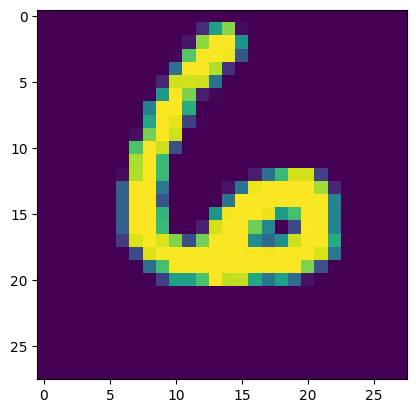

In [ ]:
img_gen(X_train,Y_train)

The image below is the 7629th image in the dataset, labeled [1], with one hot encoding [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


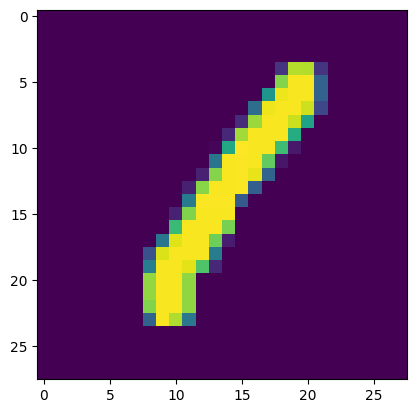

In [ ]:
img_gen(X_test,Y_test)


In [ ]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache


def sigmoid_backward(dA, cache):
    Z = cache

    a, _ = sigmoid(Z)

    dZ = dA * a * (1 - a)

    return dZ

def relu_backward(dA, cache):
    Z = cache

    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0

    return dZ

In [ ]:
a = np.array([1,2,3,4,5,6]).reshape(-1,1)
b = np.array([3,6,5,13,2,-1]).reshape(-1,1)
c = a.reshape(-1)
print(np.dot(a,b.T))
print(np.dot(a.T,b))
print(np.diag(c))

[[ 3  6  5 13  2 -1]
 [ 6 12 10 26  4 -2]
 [ 9 18 15 39  6 -3]
 [12 24 20 52  8 -4]
 [15 30 25 65 10 -5]
 [18 36 30 78 12 -6]]
[[86]]
[[1 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 4 0 0]
 [0 0 0 0 5 0]
 [0 0 0 0 0 6]]


In [ ]:
def softmax(Z):
    arb = np.exp(Z)
    A = arb / np.sum(arb, axis = 0, keepdims = True)
    cache = Z
    return A, cache

# Won't need this for now, the jacobian for multiple examples becomes kinda complicated, not sure what to do here

# def softmax_backward(dA, cache):
#     Z = cache
#     arb = -np.dot(Z, Z.T)
#     jacobian = np.diag(Z.reshape(-1)) + arb



In [ ]:
def initialize_weights(layer_dims):

    weights = {}
    L = len(layer_dims)

    for l in range(1,L):
        weights['W'+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) # * 0.01 # The initialization with * 0.01 doesnt seem to converge for cat classification, but / np.sqrt() does very quickly
        weights['b'+str(l)] = np.zeros((layer_dims[l],1))
        # weights['b'+str(l)] = np.random.randn(layer_dims[l],1) # random initialization on biases, not used for now

    return weights


In [ ]:
def forward_linear(A, W, b):

    Z = np.dot(W, A) + b
    cache = (A, W, b)

    return Z, cache

In [ ]:
def forward_activation(A_prev, W, b, activation):

    Z, linear_cache = forward_linear(A_prev, W, b)

    if activation == 'relu':
        A, activation_cache = relu(Z)
    elif activation == 'sigmoid':
        A, activation_cache = sigmoid(Z)
    elif activation == 'softmax':
        A, activation_cache = softmax(Z)

    cache = (linear_cache, activation_cache)

    return A, cache

In [ ]:
def forward_propagation(X, weights):
    caches = []
    A = X
    L = len(weights) // 2 # number of layers in the neural network

    for l in range(1,L):
        A_prev = A
        A, cache = forward_activation(A_prev, weights['W'+str(l)], weights['b'+str(l)], 'relu')
        caches.append(cache)

    AL, cache = forward_activation(A, weights['W'+str(L)], weights['b'+str(L)], 'softmax')
    caches.append(cache)

    return AL, caches

In [ ]:
def compute_cost(AL, Y, weights, lam):

    Yhot = oneHot(Y)
    classes = Yhot.shape[0]
    cost = 0

    W_sum = 0

    L = len(weights) // 2
    m = Y.shape[1]

    for l in range(L):
        W_sum = W_sum + np.sum(weights['W'+str(l+1)]**2)

    cost = (-1/m) * np.sum(Yhot * np.log(AL)) + (lam / (2 * m)) * W_sum

    return cost

In [ ]:
classes = Y.shape[0]
lam = 0
layer_dims = [n, 25, classes]

weights = initialize_weights(layer_dims)
AL, _ = forward_propagation(X_norm, weights)
print(AL.shape)
cost = compute_cost(AL, Y.T, weights, lam)

print(cost)

(1, 70000)
0.0


In [ ]:
def linear_backward(dZ, cache, lam):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T) / m + (lam / m) * W
    db = np.sum(dZ, axis = 1, keepdims = True) / m
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db


def activation_backward(dA, cache, activation, lam):
    linear_cache, activation_cache = cache

    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache, lam)

    return dA_prev, dW, db


def backward_propagation(AL, Y, caches, lam):
    L = len(caches) # number of layers of the neural network
    grads = {}
    Yhot = oneHot(Y)

    cache = caches[L-1]
    linear_cache, activation_cache = cache # softmax layer cache
    Z = activation_cache
    S, _ = softmax(Z)
    dZ = S - Yhot
    dA_prev, grads['dW'+str(L)], grads['db'+str(L)] = linear_backward(dZ, linear_cache, lam)

    for l in reversed(range(L-1)):
        dA = dA_prev
        dA_prev, grads['dW'+str(l+1)], grads['db'+str(l+1)] = activation_backward(dA, caches[l], 'relu', lam)

    return grads




In [ ]:
for i in range(1,2):
    print(f"Hello {i}")

Hello 1


In [ ]:
def update_weights(weights, grads, learning_rate):
    L = len(weights) // 2
    for l in range(L):
        weights['W'+str(l+1)] = weights['W'+str(l+1)] - learning_rate * grads['dW'+str(l+1)]
        weights['b'+str(l+1)] = weights['b'+str(l+1)] - learning_rate * grads['db'+str(l+1)]

    return weights


In [ ]:
def predict(X, weights):
    AL, _ = forward_propagation(X, weights)
    predictions = np.argmax(AL, axis = 0, keepdims = True)

    return predictions

In [ ]:
def NN_model(X, Y, layer_dims, learning_rate, iterations, lam):
    weights = {}
    caches = []
    cost_history = []
    weights = initialize_weights(layer_dims)

    for i in range(iterations):
        AL, caches = forward_propagation(X, weights)
        grads = backward_propagation(AL, Y, caches, lam)
        weights = update_weights(weights, grads, learning_rate)

        # print(AL.shape)

        cost = compute_cost(AL, Y, weights, lam)
        cost_history.append(cost)

        if i % 100 == 0:
            print(f"The cost in the {i}th iteration is: {cost}")
            p = predict(X, weights)
            print(p.shape)
            acc = accuracy_score(Y.reshape(-1), p.reshape(-1))
            print(f"The accuracy score: {acc*100} %")


    cost = compute_cost(AL, Y, weights, lam)
    cost_history.append(cost)

    plt.plot(cost_history)
    plt.xlabel('number of iterations')
    plt.ylabel('Cost')

    return weights


In [ ]:
print("The shape of the training set feature matrix is:", X_train.shape)
print("The shape of the training label vector is:", Y_train.shape)
print("The shape of the test set feature matrix is:", X_test.shape)
print("The shape of the test label vector is:", Y_test.shape)

classes = np.max(Y_train)+1

print("The number of classes is:",classes)

The shape of the training set feature matrix is: (784, 56000)
The shape of the training label vector is: (1, 56000)
The shape of the test set feature matrix is: (784, 14000)
The shape of the test label vector is: (1, 14000)
The number of classes is: 10


The cost in the 0th iteration is: 2.385709812319184
(1, 56000)
The accuracy score: 18.61785714285714 %
The cost in the 10th iteration is: 1.7456555785630332
(1, 56000)
The accuracy score: 56.987500000000004 %
The cost in the 20th iteration is: 1.2362098328265327
(1, 56000)
The accuracy score: 73.68928571428572 %
The cost in the 30th iteration is: 0.9042204765220055
(1, 56000)
The accuracy score: 80.28214285714286 %
The cost in the 40th iteration is: 0.7215922155897363
(1, 56000)
The accuracy score: 83.34107142857144 %
The cost in the 50th iteration is: 0.6157029852766568
(1, 56000)
The accuracy score: 84.92857142857143 %
The cost in the 60th iteration is: 0.5485134139186819
(1, 56000)
The accuracy score: 86.06071428571428 %
The cost in the 70th iteration is: 0.50250742855711
(1, 56000)
The accuracy score: 86.86964285714286 %
The cost in the 80th iteration is: 0.46901844134031706
(1, 56000)
The accuracy score: 87.46607142857142 %
The cost in the 90th iteration is: 0.44340101921475805
(1

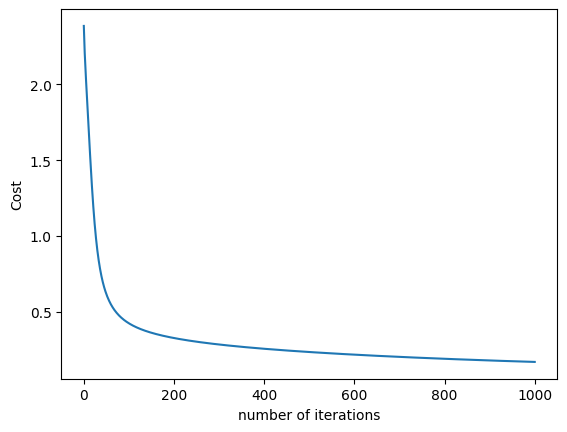

In [ ]:
# Running the neural network on our dataset
from sklearn.metrics import confusion_matrix

layer_dims = [n, 100, 100, classes]

weights = NN_model(X_train, Y_train, layer_dims, learning_rate = 0.03, iterations = 1000, lam = 1)



In [ ]:
predictions = predict(X_test, weights).reshape(-1)

print(predictions.shape)

test_score = accuracy_score(Y_test.reshape(-1), predictions)
print(f"The test accuracy is: {test_score*100}%")

conf_mat = confusion_matrix(Y_test.reshape(-1), predictions, normalize = None)

print(conf_mat)

(14000,)
The test accuracy is: 94.8%
[[1310    0    3    4    2    7    6    2   12    3]
 [   0 1550    9    4    1    5    1    2    7    2]
 [  10   11 1317    9   13    6    4   12   14    4]
 [   3    2   24 1339    0   30    1    7   19    9]
 [   1    2    1    0 1269    0    8    3    6   38]
 [   8    2    6   25    8 1183   19    1   18   16]
 [   8    1    8    1   12   12 1357    1    7    0]
 [   5    7   15    5    3    1    1 1413    2   24]
 [   5   12    8   26    4   18    8    2 1297   11]
 [   5    5    3   20   32    7    0   25   14 1237]]
